In [1]:
"""
Using Allen Data
0) Calculate seperability weights from dendrogram
1) Filter Genes to remove genes not expressed
2) Calculate weighted(by debdrogram) seperability for each gene
3) Filter genes by weighted seperability
4)
4) Hierarchical of genes by weighted F Statistic
    a) distance is Variance((gn+gm)within)/Variance((gn+gm)without)
    b) save as distance matrix
    c) find minimum distance
    d) create new distance matrix (n-1)**2
    e) copy unused distance matrix (n-2)**2
    f) fill in missing distances
        1) Variance((gnm+gv)within)/Variance((gnm+gv)without)
    g) repeat steps c-f for n-1 iterations
"""
import os
import pandas as pd
import numpy as np
from fish_helpers import *
import tqdm
import time
from scipy import sparse
base = '/bigstore/binfo/mouse/Hippocampus/'

In [386]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          dist: 20.9 GiB
                    raw_counts: 15.4 GiB
         normalized_raw_counts: 15.4 GiB
                        zscore: 697.9 MiB
                     matrix_df: 697.9 MiB
               filtered_counts: 697.8 MiB
                          _149: 697.8 MiB
                       node_df: 344.7 MiB
                          _210: 344.7 MiB
                          _188: 342.2 MiB


In [3]:
"""
Decoding dendogram
Converting to linkage
"""
import json
with open('/bigstore/binfo/mouse/Hippocampus/dend.json') as json_file:
    data = json.load(json_file)
def inspect_node(node):
    if 'leaf_attributes' in node.keys():
        attributes = node['leaf_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        a = 'None'
        b = 'None'
        children = False
    else:
        attributes = node['node_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        children = node['children']
        a_node = node['children'][0]
        if 'leaf_attributes' in a_node.keys():
            a = a_node['leaf_attributes'][0]['node_id']
        else:
            a = a_node['node_attributes'][0]['node_id']
        b_node = node['children'][1]
        if 'leaf_attributes' in b_node.keys():
            b = b_node['leaf_attributes'][0]['node_id']
        else:
            b = b_node['node_attributes'][0]['node_id']
    return c,h,a,b,children

C = []
H = []
A = []
B = []
node_dict = {}

node = data
c,h,a,b,children = inspect_node(node)
C.append(c)
H.append(h)
A.append(a)
B.append(b)
while len(children)>0:
    new_children = []
    for node in children:
        c,h,a,b,node_children = inspect_node(node)
        C.append(c)
        H.append(h)
        A.append(a)
        B.append(b)
        if isinstance(node_children,list):
            new_children.extend(node_children)
    children = new_children
linkage = pd.DataFrame()
linkage['C'] = C
linkage['H'] = H
linkage['A'] = A
linkage['B'] = B
print(len(C))
"""
Convert linkage to dendrogram format
"""
sorted_linkage = linkage.sort_values('H',ascending=True)
sorted_linkage['n'] = range(len(sorted_linkage))
nA = []
for A in sorted_linkage['A']:
    if A!='None':
        nA.append(np.array(sorted_linkage[sorted_linkage['C']==A]['n'])[0])
    else:
        nA.append('None')
nB = []
for B in sorted_linkage['B']:
    if B!='None':
        nB.append(np.array(sorted_linkage[sorted_linkage['C']==B]['n'])[0])
    else:
        nB.append('None')
sorted_linkage['nA'] = nA
sorted_linkage['nB'] = nB
sorted_linkage['nC'] = list(sorted_linkage['n'])
sorted_linkage = sorted_linkage[sorted_linkage['H']>0]
sorted_linkage = sorted_linkage.sort_values('H',ascending=True)
"""
Convert to shc format
"""
linkage_shc = np.zeros((len(sorted_linkage),4))
linkage_shc[:,0] = sorted_linkage['nA']
linkage_shc[:,1] = sorted_linkage['nB']
linkage_shc[:,2] = sorted_linkage['H']
linkage_shc[:,3] = 1

579


In [4]:
"""
Convert to cell type by node matrix
"""
def find_next_node(i,df):
    temp = df[(df['A']==i)|(df['B']==i)]
    if len(temp)==1:
        return temp['C'].iloc[0]
    else:
        return False
def linkage2binary(linkage,cells):
    nnodes = len(linkage)
    ncells = len(cells)
    binary_node_matrix = np.zeros((ncells,nnodes))
    first_node = linkage['C'].iloc[0]
    for i,cell in tqdm.tqdm(enumerate(cells),total=ncells):
        node_loc = list(linkage[linkage['C']==cell].index)[0]
        binary_node_matrix[i,node_loc]=1
        new_node = find_next_node(cell,linkage)
        while isinstance(new_node,str):
            node_loc = list(linkage[linkage['C']==new_node].index)[0]
            binary_node_matrix[i,node_loc]=1
            new_node = find_next_node(new_node,linkage)
    binary_node_df = pd.DataFrame(binary_node_matrix,index=cells,columns=list(linkage['C']))
    return binary_node_df
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
binary_node_df = linkage2binary(linkage,good_types)
binary_node_df = binary_node_df.T

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (36,54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
100%|██████████| 290/290 [00:13<00:00, 20.90it/s]


,n1,n2,n281,n3,n274,n283,n282,n4,CR,n277,...,L2/3 IT Otof_4,n151,L4/5 IT_9,L4/5 IT_10,L4/5 IT_13,L4/5 IT_14,L5 IT_8,L5 IT_9,L2/3 IT Otof_5,L2/3 IT Otof_6
L2/3 IT Otof_6,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
L4/5 IT_15,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L2/3 IT Otof_5,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
L5 IT_9,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
L4/5 IT_9,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L5 IT_11,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L6 IT_4,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L5 IT_5,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L5 IT_4,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L4/5 IT_14,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [52]:
"""
Build cell type to cell type weight matrix
"""
n_cell_types = len(good_types)
weight_matrix = np.zeros((n_cell_types,n_cell_types))
for x,cell_type1 in tqdm.tqdm(enumerate(good_types),total=n_cell_types):
    for y,cell_type2 in enumerate(good_types):
        if x<y:
            ancester_nodes = list(binary_node_df[(binary_node_df[cell_type1]==1)&(binary_node_df[cell_type2]==1)].index)
            weight = np.min(linkage[linkage['C'].isin(ancester_nodes)]['H'])
            weight_matrix[x,y] = weight
            weight_matrix[y,x] = weight
weight_matrix_df = pd.DataFrame(weight_matrix,index=good_types,columns=good_types)

100%|██████████| 290/290 [01:58<00:00,  2.45it/s]


In [8]:
"""
Load single cell matrix and metadata
"""
# raw_counts_df = pd.read_csv(os.path.join(base,'Allen/raw_counts.csv'),index_col=0)
# metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
# """
# Checking for low quality cells and removing
# """
# good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
# good_cells = list(metadata[metadata['cell_type_alias_label'].isin(good_types)].index)
# good_cells = list(set(good_cells).intersection(list(raw_counts_df.columns)))
# raw_counts_df = raw_counts_df[good_cells]
# raw_counts = np.array(raw_counts_df)
# cells = np.array(raw_counts_df.columns)
# genes = np.array(raw_counts_df.index)
# del raw_counts_df
# raw_counts_sparse = sparse.csr_matrix(raw_counts)
# sparse.save_npz(os.path.join(base,'Allen/raw_counts.npz'),raw_counts_sparse)
# pd.DataFrame(cells).to_csv(os.path.join(base,'Allen/raw_cells.csv'))
# pd.DataFrame(genes).to_csv(os.path.join(base,'Allen/raw_genes.csv'))

# """
# Loading Data from backup
# """
# raw_counts_sparse =  sparse.load_npz(os.path.join(base,'Allen/raw_counts.npz'))
# cells = np.array(pd.read_csv(os.path.join(base,'Allen/raw_cells.csv'),index_col=0)['0'])
# genes = np.array(pd.read_csv(os.path.join(base,'Allen/raw_genes.csv'),index_col=0)['0'])
# metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
# good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
# raw_counts = raw_counts_sparse.A

# """
# Filter out lowly expressing genes
# """
# gene_thresh = 5
# cell_thresh = 100
# gene_filter = np.sum(1*(raw_counts>=gene_thresh),axis=1)>cell_thresh
# genes = genes[gene_filter]
# raw_counts = raw_counts[gene_filter,:]
# raw_counts_sparse = sparse.csr_matrix(raw_counts)
# sparse.save_npz(os.path.join(base,'Allen/filtered_raw_counts.npz'),raw_counts_sparse)
# pd.DataFrame(cells).to_csv(os.path.join(base,'Allen/filtered_raw_cells.csv'))
# pd.DataFrame(genes).to_csv(os.path.join(base,'Allen/filtered_raw_genes.csv'))
"""
Loading Data from backup
"""
raw_counts_sparse =  sparse.load_npz(os.path.join(base,'Allen/filtered_raw_cells.npz'))
cells =  np.array(pd.read_csv(os.path.join(base,'Allen/filtered_raw_cells.csv'),index_col=0)['0'])
genes = np.array(pd.read_csv(os.path.join(base,'Allen/filtered_raw_genes.csv'),index_col=0)['0'])
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
raw_counts = raw_counts_sparse.A

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (36,54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [35]:
"""
Generating Cell Type Lookup Table
"""
cell_type_loc = {}
labels = np.array(metadata['cell_type_alias_label'].loc[list(cells)])
for cell_type in np.unique(labels):
    cell_type_loc[cell_type] = np.where(labels==cell_type)[0]

In [36]:
"""
Calculate median and variance for each gene for each cell type
"""
cell_types = cell_type_loc.keys()
n_cell_types = len(cell_types)
ngenes = len(genes)
cell_type_medians = np.zeros((n_cell_types,ngenes))
cell_type_variance = np.zeros((n_cell_types,ngenes))
for i,cell_type in tqdm.tqdm(enumerate(cell_types),total=n_cell_types):
    loc = cell_type_loc[cell_type]
    if len(loc)>0: # if there are no cells for that node keep as 0?
        cel_type_counts = raw_counts[:,loc]
        cell_type_medians[i,:] = np.median(cel_type_counts,axis=1)
        cell_type_variance[i,:] = np.std(cel_type_counts,axis=1)

100%|██████████| 290/290 [03:27<00:00,  1.40it/s]


In [91]:
"""
cell_type loop
elementwise
matrix subtraction of medians
matrix addition of variances
Use Nodes heights as weights
Calculate seperability for genes independantly
"""
weights = weight_matrix
seperability_matrix = np.zeros_like(cell_type_medians)
for i in tqdm.tqdm(range(n_cell_types),total=n_cell_types):
    median = cell_type_medians[i,:]
    variance = cell_type_variance[i,:]
    delta_medians = np.abs(np.subtract(cell_type_medians,median[None,:]))
    sigma_variances = np.add(cell_type_variance,variance[None,:])
    seperability = np.divide(delta_medians,sigma_variances)
    seperability[seperability==np.inf]=0
    weighted_seperability = np.multiply(seperability,weights[i,:][:,None])
    weighted_seperability[weighted_seperability==np.inf]=0
    seperability_matrix[i,:] = np.nansum(weighted_seperability,axis=0)
total_seperation = np.sum(seperability_matrix,axis=0)



  0%|          | 0/290 [00:00<?, ?it/s]/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


  0%|          | 1/290 [00:00<01:56,  2.48it/s]

  1%|          | 2/290 [00:00<01:53,  2.54it/s]

  1%|          | 3/290 [00:01<01:50,  2.60it/s]

  1%|▏         | 4/290 [00:01<01:48,  2.63it/s]

  2%|▏         | 5/290 [00:01<01:46,  2.68it/s]

  2%|▏         | 6/290 [00:02<01:44,  2.72it/s]

  2%|▏         | 7/290 [00:02<01:43,  2.73it/s]

  3%|▎         | 8/290 [00:02<01:42,  2.75it/s]

  3%|▎         | 9/290 [00:03<01:41,  2.77it/s]

  3%|▎         | 10/290 [00:03<01:40,  2.78it/s]

  4%|▍         | 11/290 [00:04<01:40,  2.77it/s]

  4%|▍         | 12/290 [00:04<01:40,  2.77it/s]

  4%|▍         | 13/290 [00:04<01:39,  2.79it/s]

  5%|▍         | 14/290 [00:05<01:38,  2.80it/s]

  5%|▌         | 15/290 [00:05<01:38,  2.79it/s]

  6%|▌         | 16/290 [00:05<01:39,  2.7

8305.303547879532


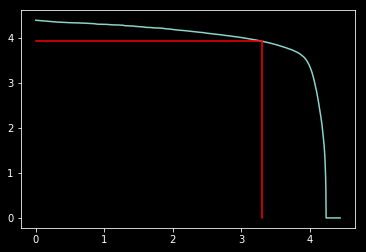

In [92]:
"""
Filter genes by weighted seperability top 2000 genes
"""
%matplotlib inline
import matplotlib.pyplot as plt
ngenes = 2000
plt.style.use(['dark_background'])
sorted_seperability = pd.DataFrame(total_seperation,index=genes,columns=['seperability']).sort_values('seperability',ascending=False)
t = np.log10(sorted_seperability['seperability'].iloc[ngenes]+1)
print(10**t)
plt.plot(np.log10(np.array(range(len(sorted_seperability)))+1),np.log10(sorted_seperability+1))
plt.plot([0,np.log10(ngenes)],[t,t],c='r')
plt.plot([np.log10(ngenes),np.log10(ngenes)],[0,t],c='r')
plt.show()

# good_genes = list(sorted_seperability.index[0:ngenes])
# filtered_counts = raw_counts[np.isin(genes,good_genes)]
# filtered_counts_sparse = sparse.csr_matrix(filtered_counts)
# sparse.save_npz(os.path.join(base,'Allen/filtered_counts.npz'),filtered_counts_sparse)

In [86]:
"""
Calculate median and variance for each gene for each cell type
"""
%matplotlib inline
import random
indexes = list(range(len(cells)))
cell_types = cell_type_loc.keys()
n_cell_types = len(cell_types)
ngenes = len(genes)
cell_type_medians_permuted = np.zeros((n_cell_types,ngenes))
cell_type_variance_permuted = np.zeros((n_cell_types,ngenes))
for i,cell_type in tqdm.tqdm(enumerate(cell_types),total=n_cell_types):
    loc = cell_type_loc[cell_type]
    if len(loc)>0: # if there are no cells for that node keep as 0?
        loc = np.array(random.sample(indexes,len(loc)))
        cel_type_counts_permuted = raw_counts[:,loc]
        cell_type_medians_permuted[i,:] = np.median(cel_type_counts_permuted,axis=1)
        cell_type_variance_permuted[i,:] = np.std(cel_type_counts_permuted,axis=1)



  0%|          | 0/290 [00:00<?, ?it/s]

  0%|          | 1/290 [00:10<48:11, 10.01s/it]

  1%|          | 2/290 [00:10<33:47,  7.04s/it]

  1%|          | 3/290 [00:10<24:03,  5.03s/it]

  1%|▏         | 4/290 [00:10<17:03,  3.58s/it]

  2%|▏         | 5/290 [00:11<12:30,  2.64s/it]

  2%|▏         | 6/290 [00:11<09:47,  2.07s/it]

  2%|▏         | 7/290 [00:11<06:59,  1.48s/it]

  3%|▎         | 8/290 [00:13<06:26,  1.37s/it]

  3%|▎         | 9/290 [00:13<05:39,  1.21s/it]

  3%|▎         | 10/290 [00:14<04:19,  1.08it/s]

  4%|▍         | 11/290 [00:14<03:17,  1.41it/s]

  4%|▍         | 12/290 [00:14<02:46,  1.67it/s]

  4%|▍         | 13/290 [00:16<04:52,  1.06s/it]

  5%|▍         | 14/290 [00:17<04:50,  1.05s/it]

  5%|▌         | 15/290 [00:18<03:45,  1.22it/s]

  6%|▌         | 17/290 [00:18<02:41,  1.69it/s]

  6%|▌         | 18/290 [00:18<02:08,  2.12it/s]

  7%|▋         | 19/290 [00:18<01:45,  2.58it/s]

  7%|▋         | 20/290 [00:18<01:23,  3.24it/s]

  8%|▊         |

In [93]:
"""
cell_type loop
elementwise
matrix subtraction of medians
matrix addition of variances
Use Nodes heights as weights
Calculate seperability for genes independantly
"""
weights = weight_matrix
seperability_matrix_permuted = np.zeros_like(cell_type_medians)
for i in tqdm.tqdm(range(n_cell_types),total=n_cell_types):
    median = cell_type_medians_permuted[i,:]
    variance = cell_type_variance_permuted[i,:]
    delta_medians = np.abs(np.subtract(cell_type_medians_permuted,median[None,:]))
    sigma_variances = np.add(cell_type_variance_permuted,variance[None,:])
    seperability = np.divide(delta_medians,sigma_variances)
    seperability[seperability==np.inf]=0
    weighted_seperability = np.multiply(seperability,weights[i,:][:,None])
    weighted_seperability[weighted_seperability==np.inf]=0
    seperability_matrix_permuted[i,:] = np.nansum(weighted_seperability,axis=0)
total_seperation_permuted = np.sum(seperability_matrix_permuted,axis=0)



  0%|          | 0/290 [00:00<?, ?it/s]/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


  0%|          | 1/290 [00:00<02:03,  2.35it/s]

  1%|          | 2/290 [00:00<01:57,  2.45it/s]

  1%|          | 3/290 [00:01<01:52,  2.56it/s]

  1%|▏         | 4/290 [00:01<01:51,  2.56it/s]

  2%|▏         | 5/290 [00:01<01:48,  2.64it/s]

  2%|▏         | 6/290 [00:02<01:45,  2.70it/s]

  2%|▏         | 7/290 [00:02<01:46,  2.67it/s]

  3%|▎         | 8/290 [00:02<01:43,  2.72it/s]

  3%|▎         | 9/290 [00:03<01:41,  2.76it/s]

  3%|▎         | 10/290 [00:03<01:43,  2.71it/s]

  4%|▍         | 11/290 [00:04<01:41,  2.75it/s]

  4%|▍         | 12/290 [00:04<01:40,  2.77it/s]

  4%|▍         | 13/290 [00:04<01:41,  2.74it/s]

  5%|▍         | 14/290 [00:05<01:39,  2.78it/s]

  5%|▌         | 15/290 [00:05<01:38,  2.79it/s]

  6%|▌         | 16/290 [00:05<01:40,  2.7

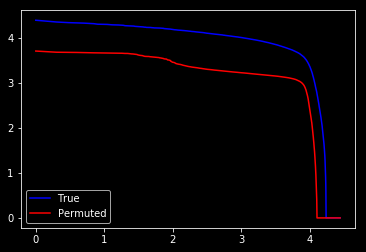

In [94]:
"""
Filter genes by weighted seperability top 2000 genes
"""
%matplotlib inline
import matplotlib.pyplot as plt
ngenes = 2000
plt.style.use(['dark_background'])
sorted_seperability = pd.DataFrame(total_seperation,index=genes,columns=['seperability']).sort_values('seperability',ascending=False)
sorted_seperability_permuted = pd.DataFrame(total_seperation_permuted,index=genes,columns=['seperability']).sort_values('seperability',ascending=False)
plt.plot(np.log10(np.array(range(len(sorted_seperability)))+1),np.log10(sorted_seperability+1),c='b',label='True')
plt.plot(np.log10(np.array(range(len(sorted_seperability_permuted)))+1),np.log10(sorted_seperability_permuted+1),c='r',label='Permuted')
plt.legend()
plt.show()

# good_genes = list(sorted_seperability.index[0:ngenes])
# filtered_counts = raw_counts[np.isin(genes,good_genes)]
# filtered_counts_sparse = sparse.csr_matrix(filtered_counts)
# sparse.save_npz(os.path.join(base,'Allen/filtered_counts.npz'),filtered_counts_sparse)

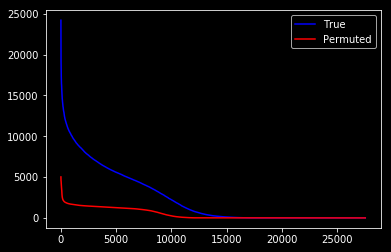

In [95]:
plt.plot(np.array(range(len(sorted_seperability))),sorted_seperability,c='b',label='True')
plt.plot(np.array(range(len(sorted_seperability_permuted))),sorted_seperability_permuted,c='r',label='Permuted')
plt.legend()
plt.show()

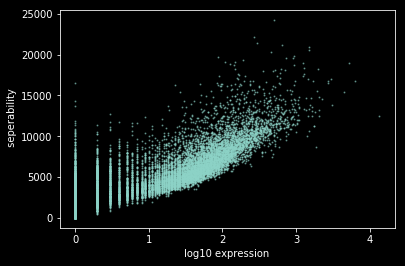

In [99]:
median_expression = pd.DataFrame(np.median(raw_counts,axis=1),index=genes)
sorted_seperability['expression'] = median_expression
plt.scatter(np.log10(sorted_seperability['expression']+1),sorted_seperability['seperability'],s=1,alpha=0.5)
plt.xlabel('log10 expression')
plt.ylabel(' seperability')
plt.show()

In [100]:
"""
Normalize by cell size
"""
normalized_raw_counts = np.divide(raw_counts,np.sum(raw_counts,axis=0))*10**6

In [126]:
"""
Calculate median and variance for each gene for each cell type
"""
indexes = list(range(len(cells)))
cell_types = cell_type_loc.keys()
n_cell_types = len(cell_types)
ngenes = len(genes)
normalized_cell_type_medians= np.zeros((n_cell_types,ngenes))
normalized_cell_type_variance = np.zeros((n_cell_types,ngenes))
for i,cell_type in enumerate(cell_types):
    loc = cell_type_loc[cell_type]
    if len(loc)>0: # if there are no cells for that node keep as 0?
        cel_type_counts = normalized_raw_counts[:,loc]
        normalized_cell_type_medians[i,:] = np.median(cel_type_counts,axis=1)
        normalized_cell_type_variance[i,:] = np.std(cel_type_counts,axis=1)
"""
cell_type loop
elementwise
matrix subtraction of medians
matrix addition of variances
Use Nodes heights as weights
Calculate seperability for genes independantly
"""
weights = weight_matrix
normalized_seperability_matrix = np.zeros_like(normalized_cell_type_medians)
for i in range(n_cell_types):
    median = normalized_cell_type_medians[i,:]
    variance = normalized_cell_type_variance[i,:]
    delta_medians = np.abs(np.subtract(normalized_cell_type_medians,median[None,:]))
    sigma_variances = np.add(normalized_cell_type_variance,variance[None,:])
    seperability = np.divide(delta_medians,sigma_variances)
    seperability[seperability==np.inf]=0
    weighted_seperability = np.multiply(seperability,weights[i,:][:,None])
    weighted_seperability[weighted_seperability==np.inf]=0
    normalized_seperability_matrix[i,:] = np.nansum(weighted_seperability,axis=0)
normalized_total_seperation = np.sum(normalized_seperability_matrix,axis=0)
"""
Calculate median and variance for each gene for each cell type
"""
indexes = list(range(len(cells)))
cell_types = cell_type_loc.keys()
n_cell_types = len(cell_types)
ngenes = len(genes)
normalized_cell_type_medians_permuted = np.zeros((n_cell_types,ngenes))
normalized_cell_type_variance_permuted = np.zeros((n_cell_types,ngenes))
for i,cell_type in enumerate(cell_types):
    loc = cell_type_loc[cell_type]
    if len(loc)>0: # if there are no cells for that node keep as 0?
        loc = np.array(random.sample(indexes,len(loc)))
        cel_type_counts_permuted = normalized_raw_counts[:,loc]
        normalized_cell_type_medians_permuted[i,:] = np.median(cel_type_counts_permuted,axis=1)
        normalized_cell_type_variance_permuted[i,:] = np.std(cel_type_counts_permuted,axis=1)
"""
cell_type loop
elementwise
matrix subtraction of medians
matrix addition of variances
Use Nodes heights as weights
Calculate seperability for genes independantly
"""
weights = weight_matrix
normalized_seperability_matrix_permuted = np.zeros_like(normalized_cell_type_medians)
for i in range(n_cell_types):
    median = normalized_cell_type_medians_permuted[i,:]
    variance = normalized_cell_type_variance_permuted[i,:]
    delta_medians = np.abs(np.subtract(normalized_cell_type_medians_permuted,median[None,:]))
    sigma_variances = np.add(normalized_cell_type_variance_permuted,variance[None,:])
    seperability = np.divide(delta_medians,sigma_variances)
    seperability[seperability==np.inf]=0
    weighted_seperability = np.multiply(seperability,weights[i,:][:,None])
    weighted_seperability[weighted_seperability==np.inf]=0
    normalized_seperability_matrix_permuted[i,:] = np.nansum(weighted_seperability,axis=0)
normalized_total_seperation_permuted = np.sum(normalized_seperability_matrix_permuted,axis=0)


/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


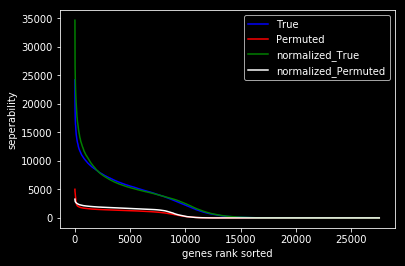

In [127]:
sorted_seperability = pd.DataFrame(total_seperation,index=genes,columns=['seperability']).sort_values('seperability',ascending=False)
sorted_seperability_permuted = pd.DataFrame(total_seperation_permuted,index=genes,columns=['seperability']).sort_values('seperability',ascending=False)
normalized_sorted_seperability = pd.DataFrame(normalized_total_seperation,index=genes,columns=['seperability']).sort_values('seperability',ascending=False)
normalized_sorted_seperability_permuted = pd.DataFrame(normalized_total_seperation_permuted,index=genes,columns=['seperability']).sort_values('seperability',ascending=False)

plt.plot(np.array(range(len(sorted_seperability))),sorted_seperability,c='b',label='True')
plt.plot(np.array(range(len(sorted_seperability_permuted))),sorted_seperability_permuted,c='r',label='Permuted')
plt.plot(np.array(range(len(normalized_sorted_seperability))),normalized_sorted_seperability,c='g',label='normalized_True')
plt.plot(np.array(range(len(normalized_sorted_seperability_permuted))),normalized_sorted_seperability_permuted,c='w',label='normalized_Permuted')
plt.xlabel('genes rank sorted')
plt.ylabel('seperability')
plt.legend()
plt.show()


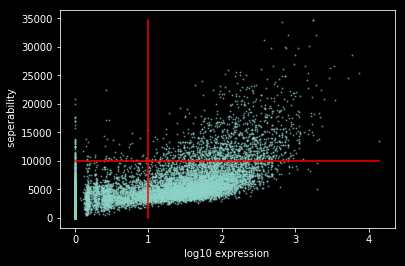

In [140]:
normalized_median_expression = pd.DataFrame(np.median(normalized_raw_counts,axis=1),index=genes)
normalized_sorted_seperability['expression'] = normalized_median_expression
plt.scatter(np.log10(normalized_sorted_seperability['expression']+1),normalized_sorted_seperability['seperability'],s=1,alpha=0.5)
plt.plot([1,1],[0,np.max(normalized_sorted_seperability['seperability'])],c='r')
plt.plot([0,np.max(np.log10(normalized_sorted_seperability['expression']+1))],[10000,10000],c='r')
plt.xlabel('log10 expression')
plt.ylabel(' seperability')
plt.show()

In [133]:
"""
Filter Genes
"""
filtered_genes = normalized_sorted_seperability[(normalized_sorted_seperability.seperability>10000)&(normalized_sorted_seperability['expression']>10)]
filtered_genes.to_csv(os.path.join(base,'Allen_best_seperable_genes.csv'))

In [145]:
"""
Save seperability filtered counts
"""
filtered_mask = np.isin(genes,np.array(filtered_genes.index))
filtered_genes = genes[filtered_mask]
filtered_counts = normalized_raw_counts[filtered_mask,:]
filtered_counts_sparse = sparse.csr_matrix(filtered_counts)
sparse.save_npz(os.path.join(base,'Allen/seperability_filtered_counts.npz'),filtered_counts_sparse)
pd.DataFrame(cells).to_csv(os.path.join(base,'Allen/seperability_filtered_cells.csv'))
pd.DataFrame(filtered_genes).to_csv(os.path.join(base,'Allen/seperability_filtered_genes.csv'))

In [154]:
import os
import sys
import time
import math
import shutil
import pickle
import random
import anndata
import operator
import matplotlib
import pylab as pl
import numpy as np
import pandas as pd
from umap import UMAP
import seaborn as sns
from scipy import sparse
from matplotlib import cm
from fish_helpers import *
from IPython import display
import tqdm.notebook as tqdm
from scipy.stats import mode
from functools import partial
from segmentation_3D import *
import matplotlib.pyplot as plt
from multiprocessing import Pool
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib._color_data as mcd
import scipy.cluster.hierarchy as shc
from scipy.interpolate import interp1d
from scipy.stats import pearsonr,spearmanr

import warnings; warnings.simplefilter('ignore')
from sklearn.metrics.pairwise import euclidean_distances


base_path = '/bigstore/GeneralStorage/Zach/CSI/Allen_CSI/'
if not os.path.exists(base_path):
    os.mkdir(base_path)
class CompressedSensingClass(object):
    def __init__(self,matrix,info_df,
                 avg=[],
                 std=[],
                 zscore=[],
                 which_genes=[],
                 subsample=1000,
                 noise = 0.1,
                 metric='cell_type',
                 nblanks=None,
                 npos=1000,
                 nbits=18,
                 ncpu=1,
                 pop_ncpu=1,
                 keepers=10,
                 mutation_rate=0.1,
                 offspring_number=0,
                 mutation_number=0,
                 k=100,
                 sample=1000,
                 survivors=[],
                 iterations=100,
                 base_path='',
                 color='r',
                 fresh=True,
                 verbose=True):
        matrix = matrix.astype('int16')
        self.noise = noise
        self.metric = metric
        self.info_df = info_df
        self.cell_types = self.info_df.cell_type.unique()
        self.fresh = fresh
        self.verbose = verbose
        if base_path == '':
            base_path = os.path.join(os.getcwd(),'Results')
        self.base_path = base_path
        if not os.path.exists(self.base_path):
            os.mkdir(self.base_path)
        self.cells = list(matrix.columns)
        self.ncells = len(self.cells)
        self.full_matrix = matrix
        if nblanks==None:
            nblanks = npos
        if nblanks>0:
            blanks = pd.DataFrame(np.zeros((nblanks,self.ncells)),index=['blank'+str(i)for i in range(nblanks)],columns=self.cells)
            if len(which_genes)==0:
                self.matrix = pd.concat([matrix,blanks])
            else:
                self.matrix = pd.concat([matrix.loc[which_genes],blanks])
        else:
            if len(which_genes)==0:
                self.matrix = matrix
            else:
                self.matrix = matrix.loc[which_genes]
                
        if len(std)==0:
            self.std = np.std(self.full_matrix,axis=1)
        else:
            self.std=std
        if len(avg)==0:
            self.avg = np.average(self.full_matrix,axis=1)
        else:
            self.avg = avg
        if len(zscore)==0:
            self.zscore = np.divide(np.subtract(self.full_matrix,avg[:,None]),std[:,None]).fillna(0)
        else:
            self.zscore = zscore
        non_zero = self.full_matrix.index[avg>0]
        self.zscore = self.zscore.loc[non_zero]
        self.avg = avg[avg>0]
        self.std = std[avg>0]
        if subsample>0:
            random_genes = random.sample(range(len(self.zscore)),subsample)
            self.zscore = self.zscore.iloc[random_genes]
            self.avg = self.avg[random_genes]
            self.std = self.std[random_genes]
        self.nblanks = nblanks
        self.genes = list(self.matrix.index)
        self.ngenes = len(self.genes)
        self.npos = npos
        self.nbits = nbits
        self.ncpu = ncpu
        self.pop_ncpu = pop_ncpu
        self.keepers = keepers
        self.ideal = np.zeros(self.ngenes)
        self.ideal[0:npos] = 1
        self.ideal = list(self.ideal)
        self.mutation_rate = mutation_rate
        self.offspring_number = offspring_number
        self.mutation_number = mutation_number
        self.k = k # could infer
        self.sample = sample
        self.survivors = survivors
        self.iterations = iterations
        self.color = color

    def generate_random(self):
        species = np.zeros((self.ngenes,self.nbits))
        mutable = int(self.npos)
        y = random.choices(range(self.nbits),k=mutable)
        x = random.choices(range(self.ngenes),k=mutable)
        species[x,y] = 1
        return species

    def generate_starting_survivors(self):
        survivors = []
        for k in range(self.keepers):
            survivors.append(self.generate_random())
        self.survivors = survivors

    def generate_mutations(self,species):
        mutated = species.copy()
        possible_mutations = self.generate_random()
        mutable = int(random.random()*self.mutation_rate*self.ngenes*self.nbits)
        y = random.choices(range(self.nbits),k=mutable)
        x = random.choices(range(self.ngenes),k=mutable)
        mutated[x,y] = possible_mutations[x,y]
        return mutated

    def generate_offspring(self,species,mate):
        offspring = species.copy()
        mutable = int(0.5*self.ngenes*self.nbits)
        y = random.choices(range(self.nbits),k=mutable)
        x = random.choices(range(self.ngenes),k=mutable)
        offspring[x,y] = mate[x,y]
        return offspring

    def generate_progenerators(self):
        progenerators = self.survivors.copy()
        for species in self.survivors:
            for i in range(self.offspring_number):
                mate = self.survivors[random.randint(0,self.keepers-1)].copy()
                progenerators.append(self.generate_offspring(species,mate))
        self.progenerators = progenerators

    def pfunc_generate_mutations(self,species):
        ppopulation = []
        for i in range(self.mutation_number):
            ppopulation.append(self.generate_mutations(species))
        return ppopulation

    def generate_population(self):
        population = self.progenerators.copy()
        if self.mutation_number>0:
            if self.pop_ncpu==1:
                for species in self.progenerators:
                    for i in range(self.mutation_number):
                        population.append(self.generate_mutations(species))
            else:
                sys.stdout.flush()
                with Pool(self.pop_ncpu) as p:
                    for ppopulation in p.imap(self.pfunc_generate_mutations,self.progenerators,chunksize=1):
                        for species in ppopulation:
                            population.append(species)
                sys.stdout.flush()
        self.population = population

    def generate_compressed(self,species):
        compressed = pd.DataFrame(index=self.cells)
        temp_matrix = np.array(self.matrix)
        out = []
        for i in range(self.nbits):
            compressed[i] = np.sum(np.multiply(temp_matrix,species[:,i][...,None]),axis=0)
        return compressed

    def calculate_metric(self,compressed):
        X = np.array(compressed.copy())
        cells = np.array(self.cells)
        n = random.sample(list(range(self.ncells)),int(self.sample*self.ncells))
        noise = np.random.randn(len(n),self.nbits)
        sim = X[n,:]+(self.noise*X[n,:]*noise)
        dist = euclidean_distances(X, sim)
        rank = dist.argpartition(self.k+1,axis=0)[:self.k+1,:]
        metrics = []
        for i,idx in enumerate(n):
            cell = cells[idx]
            knn = cells[rank[:,i]]
            knn = knn[knn!=cell]
            if self.metric =='imputation':
                zsig = self.zscore[cell]
                znn = np.average(self.zscore[knn[1:]],axis=1)
                metric = spearmanr(zsig,znn)[0]
            elif self.metric == 'cell_type':
                cell = self.info_df.loc[knn[0]].cell_type
                temp_df = self.info_df.loc[knn[1:]]
                metric = len(temp_df[temp_df.cell_type==cell])/self.k
            elif self.metric == 'dendogram':
                print('Not implemented')
            metrics.append(metric)
        metric = np.average(metrics)
        return metric

    def pfunc(self,species):
        compressed = self.generate_compressed(species)
        metric = self.calculate_metric(compressed)
        return species,compressed,metric
    
    def selection(self):
        new_population = []
        compresseds = []
        metrics = []
        if self.ncpu==1:
            for species in tqdm.tqdm(self.population):
                species,compressed,metric = self.pfunc(species)
                new_population.append(species)
                compresseds.append(compressed)
                metrics.append(metric)
        else:
            sys.stdout.flush()
            with Pool(self.ncpu) as p:
                for species,compressed,metric in tqdm.tqdm(p.imap(self.pfunc,self.population,chunksize=1),total=len(self.population)):
                    new_population.append(species)
                    compresseds.append(compressed)
                    metrics.append(metric)
            sys.stdout.flush()
        df = pd.DataFrame(index=range(len(self.population)))
        df['population'] = new_population
        df['metrics'] = metrics
        df['compresseds'] = compresseds
        df = df.sort_values('metrics',ascending=False)
        survivors = df.iloc[:self.keepers]
        self.metrics = list(survivors['metrics'])
        self.compresseds = list(survivors['compresseds'])
        self.survivors = list(survivors['population'])
        self.elite_survivor = self.survivors[0]
    
    def populate(self):
        self.generate_progenerators()
        self.generate_population()
            
    def evolve(self):
        start_time = time.time()
        self.X = []
        self.Y = []
        self.max = []
        self.min = []
        if len(self.survivors) != self.keepers:
            self.generate_starting_survivors()
        display.clear_output(wait=True)
        for I in range(self.iterations):
            if self.verbose:
                print('Iteration '+str(I))
            self.populate()
            if self.verbose:
                print('Population Generated '+str(len(self.population)))
            self.selection()
            if self.verbose:
                print('Selection Complete')
            pickle.dump(self.elite_survivor,open(os.path.join(self.base_path,str('elite_survivor_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.survivors,open(os.path.join(self.base_path,str('survivors_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.metrics,open(os.path.join(self.base_path,str('metrics_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.compresseds,open(os.path.join(self.base_path,str('compresseds_'+str(I)+'.pkl')),'wb'))
            avg = np.average(self.metrics)
            std = np.std(self.metrics) 
            self.X.append((time.time()-start_time)/(60*60))
            self.Y.append(avg)
            self.max.append(avg+std)
            self.min.append(avg-std)
            if self.verbose:
                pl.plot(self.X,self.Y,c='k',linewidth=1)
                pl.fill_between(self.X,self.max,self.min,color=self.color)
                if self.metric =='imputation':
                    pl.ylabel('Zscore correlation')
                elif self.metric == 'cell_type':
                    pl.ylabel('Average % Accurate')
                elif self.metric == 'dendogram':
                    pl.ylabel('Average metric')
                pl.xlabel('Time Hours')
                display.clear_output(wait=True)
                display.display(pl.gcf())
            if I>10:
                if np.average(self.Y[-5:])==self.Y[-1]:
                    break
        if self.verbose:
            display.clear_output(wait=True)


In [165]:
"""
Filtered CSI matrix format
"""
matrix_df = pd.DataFrame(filtered_counts,index=filtered_genes,columns=cells)
avg = np.median(filtered_counts,axis=1)
std = np.std(filtered_counts,axis=1)
zscore = pd.DataFrame(filtered_counts-avg[:,None]/std[:,None],index=filtered_genes,columns=cells)
info_df = metadata.loc[cells]
info_df['cell_type'] = info_df['cell_type_alias_label']
CSC = CompressedSensingClass(matrix_df,info_df,
                             avg=avg,
                             std=std,
                             zscore=zscore,
                             subsample=0,
                             noise=0.05,
                             which_genes=[],
                             metric='cell_type',
                             nblanks=0,
                             npos=800,
                             nbits=18,
                             ncpu=1,
                             pop_ncpu=1,
                             keepers=3,
                             mutation_rate=0.4,
                             offspring_number=0,
                             mutation_number=2,
                             k=10,
                             sample=0.15,
                             survivors=[],
                             iterations=1000,
                             base_path=base_path,
                             color='r',
                             fresh=True,
                             verbose=True)

In [166]:
"""
Filtered Random Matrix CSI KNN Simulation 
"""
CSC.sample = 0.15
CSC.noise = 0.05
random_measurement = CSC.generate_random()
simulated_compressed = CSC.generate_compressed(random_measurement)

0.3568252556691863


In [207]:
import tqdm
node_matrix = np.zeros((len(cells),len(binary_node_df.index)))
for cell_type in tqdm.tqdm(good_types):
    cell_type_cells = list(metadata[metadata['cell_type_alias_label']==cell_type].index)
    cell_type_cells = list(set(cell_type_cells).intersection(cells))
    cell_type_node = np.array(binary_node_df[cell_type])
    node_matrix[np.where(np.isin(cells,cell_type_cells)),:] = cell_type_node
node_df = pd.DataFrame(node_matrix,index=cells,columns=binary_node_df.index)




  0%|          | 0/290 [00:00<?, ?it/s]


  0%|          | 1/290 [00:02<10:47,  2.24s/it]


  1%|          | 2/290 [00:03<08:58,  1.87s/it]


  1%|          | 3/290 [00:11<18:24,  3.85s/it]


  1%|▏         | 4/290 [00:12<13:52,  2.91s/it]


  2%|▏         | 5/290 [00:13<11:45,  2.47s/it]


  2%|▏         | 6/290 [00:14<08:36,  1.82s/it]


  2%|▏         | 7/290 [00:14<07:00,  1.49s/it]


  3%|▎         | 8/290 [00:15<05:48,  1.23s/it]


  3%|▎         | 9/290 [00:16<05:27,  1.17s/it]


  3%|▎         | 10/290 [00:19<07:31,  1.61s/it]


  4%|▍         | 11/290 [00:19<06:10,  1.33s/it]


  4%|▍         | 12/290 [00:25<12:15,  2.65s/it]


  4%|▍         | 13/290 [00:27<10:57,  2.37s/it]


  5%|▍         | 14/290 [00:28<09:45,  2.12s/it]


  5%|▌         | 15/290 [00:31<10:31,  2.30s/it]


  6%|▌         | 16/290 [00:32<08:07,  1.78s/it]


  6%|▌         | 17/290 [00:32<06:23,  1.40s/it]


  6%|▌         | 18/290 [00:32<04:37,  1.02s/it]


  7%|▋         | 19/290 [00:34<05:07,  1.13s/i

In [277]:
def knn_impute_dendrogram_position(reference,measurement,node_df,k=1):
    ref_cells = np.array(reference.index)
    reference = np.array(reference)
    cells = np.array(measurement.index)
    ncells = len(cells)
    k = 1
    dist = euclidean_distances(reference, np.array(measurement))
    print('Distances Calculated')
    rank = dist.argpartition(k+1,axis=0)[:k+1,:]
    print('Distances Ranked')
    imputed_node_df = pd.DataFrame(index=cells,columns=node_df.columns)
    nn_cells = ref_cells[rank[1,:]]
    print('NN Found')
    temp = node_df.loc[nn_cells]
    temp.index = cells
    imputed_node_df.loc[cells] = temp
    return imputed_node_df
measurement = simulated_compressed.loc[random.sample(list(simulated_compressed.index),int(len(simulated_compressed)*0.5))]
imputed_node_df = knn_impute_dendrogram_position(simulated_compressed,measurement,node_df,k=1)

Distances Calculated
Distances Ranked
NN Found


In [278]:
def calculate_accuracy_dendrogram(truth,imputed):
    accuracy_matrix = np.zeros(len(imputed.columns))
    false_positive_rate_matrix = np.zeros(len(imputed.columns))
    false_negative_rate_matrix = np.zeros(len(imputed.columns))
    for i,node in tqdm.tqdm(enumerate(imputed.columns),total=len(imputed.columns)):
        imputed_cells = list(imputed[imputed[node]==1].index)
        truth_cells = list(truth[truth[node]==1].index)
        true = len(set(imputed_cells).intersection(truth_cells))
        fp = len(imputed_cells)-true
        fn = len(truth_cells)-true
        ltruth = len(truth_cells)
        if ltruth>0:
            accuracy_matrix[i] = true/ltruth
            false_positive_rate_matrix[i] = fp/ltruth
            false_negative_rate_matrix[i] = fn/ltruth
        else:
            accuracy_matrix[i] = 0
            false_positive_rate_matrix[i] = 0
            false_negative_rate_matrix[i] = 0
    return accuracy_matrix,false_positive_rate_matrix,false_negative_rate_matrix
truth_node_df = node_df.loc[measurement.index]
accuracy_matrix,false_positive_rate_matrix,false_negative_rate_matrix = calculate_accuracy_dendrogram(truth_node_df,imputed_node_df)
accuracy_matrix_df = pd.DataFrame(accuracy_matrix,index=imputed.columns)





  0%|          | 0/579 [00:00<?, ?it/s]



  0%|          | 1/579 [00:00<03:15,  2.95it/s]



  0%|          | 2/579 [00:00<03:20,  2.88it/s]



  1%|          | 4/579 [00:01<02:49,  3.39it/s]



  1%|▏         | 8/579 [00:01<02:14,  4.23it/s]



  3%|▎         | 16/579 [00:01<01:37,  5.79it/s]



  3%|▎         | 18/579 [00:01<01:31,  6.11it/s]



  4%|▍         | 26/579 [00:02<01:05,  8.42it/s]



  5%|▌         | 30/579 [00:02<00:58,  9.38it/s]



  7%|▋         | 42/579 [00:02<00:41, 12.86it/s]



  8%|▊         | 47/579 [00:02<00:33, 15.74it/s]



  9%|▉         | 52/579 [00:02<00:31, 16.48it/s]



 10%|▉         | 56/579 [00:03<00:27, 18.99it/s]



 10%|█         | 60/579 [00:03<00:23, 22.07it/s]



 11%|█         | 64/579 [00:03<00:26, 19.42it/s]



 12%|█▏        | 69/579 [00:03<00:24, 21.25it/s]



 13%|█▎        | 73/579 [00:03<00:21, 23.88it/s]



 13%|█▎        | 76/579 [00:03<00:26, 18.74it/s]



 14%|█▍        | 80/579 [00:04<00:22, 21.94it/s]



 15%|█▍        | 85/5

(array([20., 51., 51., 70., 83., 67., 69., 50., 63., 55.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

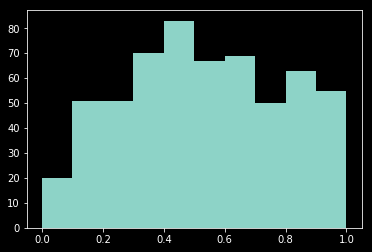

In [279]:
plt.hist(accuracy_matrix)

In [305]:
"""
Convert linkage to dendrogram format
"""
sorted_linkage = linkage.sort_values('H',ascending=True)
sorted_linkage['n'] = range(len(sorted_linkage))
nA = []
for A in sorted_linkage['A']:
    if A!='None':
        nA.append(np.array(sorted_linkage[sorted_linkage['C']==A]['n'])[0])
    else:
        nA.append('None')
nB = []
for B in sorted_linkage['B']:
    if B!='None':
        nB.append(np.array(sorted_linkage[sorted_linkage['C']==B]['n'])[0])
    else:
        nB.append('None')
sorted_linkage['nA'] = nA
sorted_linkage['nB'] = nB
sorted_linkage['nC'] = list(sorted_linkage['n'])
sorted_linkage = sorted_linkage[sorted_linkage['H']>0]
sorted_linkage = sorted_linkage.sort_values('H',ascending=True)
"""
Convert to shc format
"""
linkage_shc = np.zeros((len(sorted_linkage),4))
linkage_shc[:,0] = sorted_linkage['nA']
linkage_shc[:,1] = sorted_linkage['nB']
linkage_shc[:,2] = sorted_linkage['H']
linkage_shc[:,3] = 1

,C,H,A,B,n,nA,nB,nC
558,n173,0.0120,L4/5 IT_9,L4/5 IT_10,290,275,254,290
456,n56,0.0130,L6 CT_9,L6 CT_10,291,114,115,291
561,n177,0.0131,L4/5 IT_13,L4/5 IT_14,292,273,274,292
564,n165,0.0138,L5 IT_8,L5 IT_9,293,282,279,293
418,n265,0.0159,Sst_10,Sst_11,294,99,98,294
523,n168,0.0164,L4/5 IT_3,L4/5 IT_4,295,237,240,295
570,n151,0.0168,L2/3 IT Otof_5,L2/3 IT Otof_6,296,15,0,296
548,n176,0.0171,n177,L4/5 IT_15,297,292,284,297
502,n87,0.0175,L5 ET_6,L5 ET_7,298,247,246,298
499,n159,0.0178,L5 IT_4,L5 IT_5,299,251,220,299


In [306]:
"""
Convert to shc format
"""
linkage_shc = np.zeros((len(sorted_linkage),4))
linkage_shc[:,0] = sorted_linkage['nA']
linkage_shc[:,1] = sorted_linkage['nB']
linkage_shc[:,2] = sorted_linkage['H']
linkage_shc[:,3] = 1
linkage_shc

array([[2.750e+02, 2.540e+02, 1.200e-02, 1.000e+00],
       [1.140e+02, 1.150e+02, 1.300e-02, 1.000e+00],
       [2.730e+02, 2.740e+02, 1.310e-02, 1.000e+00],
       ...,
       [5.700e+02, 5.740e+02, 6.271e-01, 1.000e+00],
       [5.750e+02, 5.670e+02, 7.175e-01, 1.000e+00],
       [5.760e+02, 5.770e+02, 8.416e-01, 1.000e+00]])

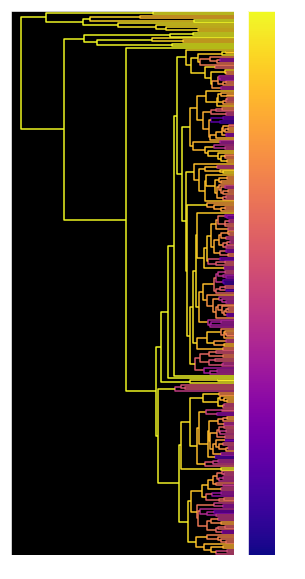

In [384]:
import matplotlib as mpl
def plot_dendrogram(linkage,accuracy_matrix):
    Z = linkage.copy()
    Z[:,2] = np.log10(Z[:,2]+1)
    cmap = matplotlib.cm.plasma(accuracy_matrix)
    temp = [matplotlib.colors.rgb2hex(rgb[:3]) for rgb in cmap]
    link_cols = {}
    for i,c in enumerate(temp):
        link_cols[i] = c
    ax = plt.figure(figsize=[5,10])
    D = shc.dendrogram(Z=Z,
                       link_color_func=lambda x: link_cols[x],
                       orientation='left',no_labels=True)
    norm = mpl.colors.Normalize(vmin=0,vmax=1)
    sm = plt.cm.ScalarMappable(norm=norm,cmap='plasma')
    sm.set_array([])
    plt.colorbar(sm)
    plt.show()
%matplotlib inline
accuracy = np.array(accuracy_matrix_df.loc[linkage.sort_values('H',ascending=True)['C']][0])
plot_dendrogram(linkage_shc,accuracy)

32


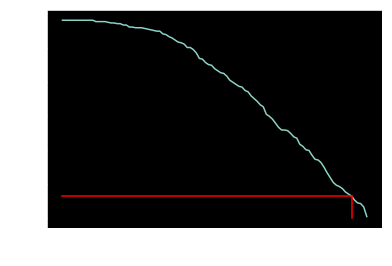

In [490]:
temp = linkage
temp.index = temp['C']
temp['Accuracy'] = accuracy_matrix_df[0]
temp = temp[temp['H']>0]
x = np.linspace(0,1,101)
y = []
for i in x:
    local = temp[temp['Accuracy']>=i]
    good_leaves = np.unique(list(np.unique(local['A']))+list(np.unique(local['B'])))
    good_nodes = np.unique(local['C'])
    not_shared = set(list(good_leaves)).symmetric_difference(list(good_nodes))
    n = len(set(list(not_shared)).intersection(list(good_leaves)))
    y.append(n)

thresh = 0.95
value = y[-6]
print(value)
plt.plot(x,y)
plt.plot([thresh,thresh],[0,value],c='r')
plt.plot([0,thresh],[value,value],c='r')
plt.ylabel('n leaves >accuracy')
plt.xlabel('accuracy threshold')
plt.show()

In [492]:
local = temp[temp['Accuracy']>=0.95]
good_leaves = np.unique(list(np.unique(local['A']))+list(np.unique(local['B'])))
good_nodes = np.unique(local['C'])
not_shared = set(list(good_leaves)).symmetric_difference(list(good_nodes))
n = len(set(list(not_shared)).intersection(list(good_leaves)))

In [494]:
set(list(not_shared)).intersection(list(good_leaves))

{'Astro_1',
 'Astro_2',
 'CA3sp_5',
 'CR',
 'DG_1',
 'DG_2',
 'DG_3',
 'Endo_1',
 'Endo_2',
 'L2/3 IT Cxcl14_1',
 'Macrophage_1',
 'Macrophage_2',
 'Oligo_4',
 'Oligo_5',
 'Oligo_6',
 'RSP/ACA L4/5 IT_1',
 'Sst Chodl_1',
 'Sst Chodl_2',
 'VLMC_4',
 'VLMC_5',
 'n11',
 'n185',
 'n229',
 'n27',
 'n271',
 'n279',
 'n286',
 'n288',
 'n32',
 'n72',
 'n93',
 'n99'}

In [405]:
"""
Is there a better way to organize these genes
"""
cell_types = metadata['cell_type_alias_label'].unique()
normalized_filterd_cell_type_medians = np.zeros((len(cell_types),len(filtered_genes)))
normalized_filterd_cell_type_variances = np.zeros((len(cell_types),len(filtered_genes)))                                       
for i,cell_type in enumerate(cell_types):
    cell_type_cells = list(metadata[metadata['cell_type_alias_label']==cell_type].index)
    cell_type_cells = list(set(cell_type_cells).intersection(list(matrix_df.columns)))
    if len(cell_type_cells)>0:
        cell_type_df = matrix_df[cell_type_cells]
        normalized_filterd_cell_type_medians[i,:] = np.median(cell_type_df,axis=1)
        normalized_filterd_cell_type_variances[i,:] = np.std(cell_type_df,axis=1)


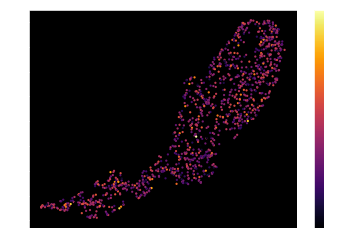

In [431]:
latent_u = UMAP(spread=2).fit_transform(normalized_filterd_cell_type_medians.T)
order = np.arange(latent_u.shape[0])
random.shuffle(order)
plt.scatter(latent_u[order, 0], latent_u[order, 1],
           c=np.log10(np.median(matrix_df,axis=1)+1),
           cmap='inferno', edgecolors='none', s=5)
plt.colorbar()
# plt.axis("off")
fig.set_tight_layout(True)

In [435]:
met_cells = list(set(list(metadata.index)).intersection(list(matrix_df.columns)))

In [439]:
cell_type_conversion = {celltype:i for i,celltype in enumerate(cell_types)}

In [442]:
colors = np.array([cell_type_conversion[ct] for ct in metadata['cell_type_alias_label'].loc[met_cells]])

In [443]:
latent_u = UMAP(spread=2).fit_transform(np.array(matrix_df.T.loc[met_cells]))
fig, ax = plt.subplots(figsize=(5, 5))
order = np.arange(latent_u.shape[0])
random.shuffle(order)
N = len(cell_types)
cm = mcolors.LinearSegmentedColormap.from_list(
        'my_cm', np.random.choice(list(mcolors.CSS4_COLORS.keys()),N), N=N)
ax.scatter(latent_u[order, 0], latent_u[order, 1], 
           c=colors[order], 
           cmap=cm, edgecolors='none', s=5)
plt.axis("off")
# custom_lines = [Line2D([0], [0], color=cm(i), lw=2) for i in range(len(cell_types))]
# ax.legend(custom_lines, list(cell_types))
fig.set_tight_layout(True)

KeyboardInterrupt: 

In [ ]:
latent_u = UMAP(spread=2).fit_transform(normalized_filterd_cell_type_medians)
fig, ax = plt.subplots(figsize=(5, 5))
order = np.arange(latent_u.shape[0])
random.shuffle(order)
N = normalized_filterd_cell_type_medians.shape[0]
cm = mcolors.LinearSegmentedColormap.from_list(
        'my_cm', np.random.choice(list(mcolors.CSS4_COLORS.keys()),N), N=N)
ax.scatter(latent_u[order, 0], latent_u[order, 1], 
           c=np.array(range(len(cell_types)))[order], 
           cmap=cm, edgecolors='none', s=5)
plt.axis("off")
# custom_lines = [Line2D([0], [0], color=cm(i), lw=2) for i in range(len(cell_types))]
# ax.legend(custom_lines, list(cell_types))
fig.set_tight_layout(True)

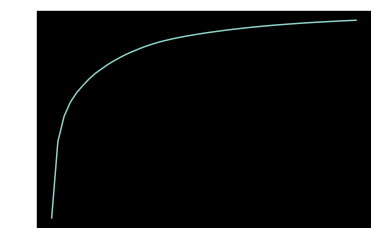

In [455]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(normalized_filterd_cell_type_medians.T)
plt.plot(range(0,50),np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [ ]:
"""
Using Genetic algorithm on dendrogram
"""

In [509]:
"""
Metric for dendrogram accuracy
sum of (weights+1 * accuracy)/ncells 
weights = node by weight df linkage['H']
ncells = node by ncells df from node_df
could be same df
"""
node_metrics = pd.DataFrame(index=node_df.columns)
node_metrics['weights'] = 1+pd.DataFrame(linkage['H'])
node_metrics['ncells'] = pd.DataFrame(node_df.sum())
node_metrics

,weights,ncells
n1,1.8416,74967.0
n2,1.6271,74101.0
n281,1.7175,866.0
n3,1.3650,72893.0
n274,1.5365,1208.0
n283,1.5418,681.0
n282,1.2631,185.0
n4,1.2512,72854.0
CR,1.0000,39.0
n277,1.4810,1057.0


In [530]:
accuracy_matrix_df = pd.DataFrame(accuracy_matrix_df[0])

In [531]:
pd.concat([accuracy_matrix_df,node_metrics],axis=1)

,0,weights,ncells
n1,1.000000,1.8416,74967.0
n2,0.999973,1.6271,74101.0
n281,0.995526,1.7175,866.0
n3,0.999918,1.3650,72893.0
n274,0.998384,1.5365,1208.0
n283,0.997199,1.5418,681.0
n282,0.977778,1.2631,185.0
n4,0.999863,1.2512,72854.0
CR,0.777778,1.0000,39.0
n277,0.994444,1.4810,1057.0


In [527]:
temp_accuracy_matrix_df = pd.concat([accuracy_matrix_df,node_metrics],axis=1)

,0,weights,ncells
n1,1.000000,1.8416,74967.0
n2,0.999973,1.6271,74101.0
n281,0.995526,1.7175,866.0
n3,0.999918,1.3650,72893.0
n274,0.998384,1.5365,1208.0
n283,0.997199,1.5418,681.0
n282,0.977778,1.2631,185.0
n4,0.999863,1.2512,72854.0
CR,0.777778,1.0000,39.0
n277,0.994444,1.4810,1057.0


In [525]:
accuracy_matrix_df

,0
n1,1.000000
n2,0.999973
n281,0.995526
n3,0.999918
n274,0.998384
n283,0.997199
n282,0.977778
n4,0.999863
CR,0.777778
n277,0.994444


In [201]:
"""
Convert to nodes by node matrix
"""
binary_node_df2 = linkage2binary(linkage,list(linkage['C']))
binary_node_df2 = binary_node_df2.T


100%|██████████| 579/579 [00:27<00:00, 21.02it/s]


,n1,n2,n281,n3,n274,n283,n282,n4,CR,n277,...,L2/3 IT Otof_4,n151,L4/5 IT_9,L4/5 IT_10,L4/5 IT_13,L4/5 IT_14,L5 IT_8,L5 IT_9,L2/3 IT Otof_5,L2/3 IT Otof_6
n1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n281,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n274,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n283,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n282,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n4,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CR,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n277,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
"""
Calcualte Node Cell Type Composition and Cell Locations
"""
cell_type_labels = np.array(metadata['cell_type_alias_label'].loc[cells])
node_cell_loc = {}
node_cell_types = {}
for node in tqdm.tqdm(binary_node_df.columns):
    node_cell_types_list = list(binary_node_df[binary_node_df[node]==1].index)
    node_cell_types[node] = node_cell_types_list
    locations = []
    for cell_type in node_cell_types_list:
        locations.extend(list(np.where(cell_type_labels==cell_type)[0]))
    node_cell_loc[node] = np.unique(locations)


100%|██████████| 579/579 [00:02<00:00, 288.46it/s]


In [131]:
"""
Calculate median and variance for each gene for each node
"""
n_cell_nodes = len(binary_node_df.columns)
ngenes = len(genes)
cell_node_medians = np.zeros((n_cell_nodes,ngenes))
cell_node_variance = np.zeros((n_cell_nodes,ngenes))
for i,node in tqdm.tqdm(enumerate(binary_node_df.columns),total=n_cell_nodes):
    loc = node_cell_loc[node]
    if len(loc)>0: # if there are no cells for that node keep as 0?
        node_counts = raw_counts[:,loc]
        cell_node_medians[i,:] = np.median(node_counts,axis=1)
        cell_node_variance[i,:] = np.std(node_counts,axis=1)


100%|██████████| 579/579 [04:39<00:00,  2.07it/s]


In [218]:
"""
Build Node to Node weight matrix
"""
weight_matrix = np.zeros((n_cell_nodes,n_cell_nodes))
for x,node1 in enumerate(binary_node_df2.columns):
    for y,node2 in enumerate(binary_node_df2.columns):
        if x<y:
            ancester_nodes = list(binary_node_df2[(binary_node_df2[node1]==1)&(binary_node_df2[node2]==1)].index)
            weight = np.min(linkage[linkage['C'].isin(ancester_nodes)]['H'])
            weight_matrix[x,y] = weight
            weight_matrix[y,x] = weight
weight_matrix_df = pd.DataFrame(weight_matrix,index=binary_node_df.columns,columns=binary_node_df.columns)

n1
n2
n281
n3
n274
n283
n282
n4
CR
n277
n275
n284
n288
Macrophage_1
Macrophage_2
n183
n5
n278
n279
Oligo_4
n276
n285
VLMC_5
n289
n290
n184
n271
n6
n8
Astro_1
Astro_2
n280
Oligo_3
Oligo_5
Oligo_6
n286
VLMC_4
Endo_1
Endo_2
Endo_3
SMC
n185
n229
PIR Six3
n272
DG_1
n7
RSP/ACA L4/5 IT_1
n9
Oligo_1
Oligo_2
n287
VLMC_3
n186
n196
n230
n231
n273
Meis2_3
DG_2
DG_3
L2/3 IT Cxcl14_1
n10
VLMC_1
VLMC_2
n191
n187
n213
n197
Sst Chodl_1
Sst Chodl_2
n240
n232
Meis2_1
Meis2_2
n31
n11
n192
Lamp5_6
n188
Lamp5 Lhx6_5
n216
n214
n208
n198
n241
n244
n234
n233
n71
n32
n12
CA2sp/IG
n194
n193
n189
Lamp5 Lhx6_4
n217
n225
n215
Serpinf1_3
n209
n211
n199
n200
Sst_1
n242
n245
n267
n235
n237
Pvalb_11
Pvalb_12
n92
n72
n60
n33
n13
n25
Lamp5_1
n195
Lamp5_4
Lamp5_5
n190
Lamp5 Lhx6_3
n218
n222
n226
Sncg/Ndnf HPF_6
Serpinf1_1
Serpinf1_2
Vip_1
n210
Vip_4
n212
Vip_7
Vip_8
n206
n201
Sst_2
n243
n246
n247
n269
n268
Pvalb_4
n236
n238
Pvalb_10
n99
n93
n73
POST-PRE-PAR Ptgfr
n62
n61
n42
n34
n15
n14
n28
n26
Lamp5_2
Lamp5_3
Lamp5 Lhx6_

In [ ]:
"""
Node loop
elementwise
matrix subtraction of medians
matrix addition of variances
Use Nodes heights as weights
Calculate seperability for genes independantly
"""
import tqdm
weights = weight_matrix
seperability_matrix = np.zeros_like(cell_node_medians)
for i in tqdm.tqdm(range(n_cell_nodes),total=n_cell_nodes):
    median = cell_node_medians[i,:]
    variance = cell_node_variance[i,:]
    delta_medians = np.abs(np.subtract(cell_node_medians,median[None,:]))
    sigma_variances = np.add(cell_node_variance,variance[None,:])
    seperability = np.divide(delta_medians,sigma_variances)
    seperability[seperability==np.inf]=0
    weighted_seperability = np.divide(seperability,weights[i,:][:,None])
    weighted_seperability[weighted_seperability==np.inf]=0
    seperability_matrix[i,:] = np.nansum(weighted_seperability,axis=0)
total_seperation = np.sum(seperability_matrix,axis=0)

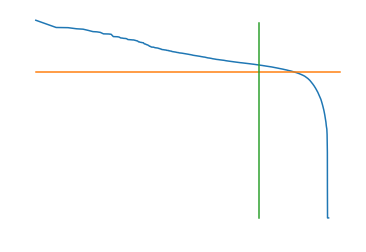

In [240]:
"""
Filter genes by weighted seperability top 2000 genes
"""
%matplotlib inline
import matplotlib.pyplot as plt
ngenes = 2000
plt.style.use(['dark_background'])
sorted_seperability = pd.DataFrame(total_seperation,index=genes,columns=['seperability']).sort_values('seperability',ascending=False)
plt.plot(np.log10(np.array(range(len(sorted_seperability)))+1),np.log10(sorted_seperability+1))
plt.plot([0,4.5],[6,6])
plt.plot([np.log10(ngenes),np.log10(ngenes)],[0,8])
plt.show()
good_genes = list(sorted_seperability.index[0:ngenes])
filtered_counts = raw_counts[np.isin(genes,good_genes)]

In [ ]:
"""
Calculate seperability for all combinations of the top genes
"""

In [ ]:
"""
Calculate median and variance for each gene for each node
"""
n_cell_nodes = len(binary_node_df.columns)
ngenes = len(good_genes)
cell_node_medians = np.zeros((n_cell_nodes,ngenes,ngenes))
cell_node_variance = np.zeros((n_cell_nodes,ngenes,ngenes))
for i,node in tqdm.tqdm(enumerate(binary_node_df.columns),desc='Nodes',total=n_cell_nodes):
    loc = node_cell_loc[node]
    if len(loc)>0: # if there are no cells for that node keep as 0?
        node_counts = filtered_counts[:,loc]
        for g in range(ngenes):
            node_gene_counts = np.add(node_counts,node_counts[g,:])
            cell_node_medians[i,:,g] = np.median(node_gene_counts,axis=1)
            cell_node_variance[i,:,g] = np.std(node_gene_counts,axis=1)







Nodes:   0%|          | 0/579 [00:00<?, ?it/s]





Nodes:   0%|          | 1/579 [39:55<384:36:39, 2395.50s/it]





Nodes:   0%|          | 2/579 [1:14:39<368:59:13, 2302.17s/it]





Nodes:   1%|          | 3/579 [1:14:50<258:19:39, 1614.55s/it]





Nodes:   1%|          | 4/579 [1:53:16<291:03:05, 1822.24s/it]





Nodes:   1%|          | 5/579 [1:53:31<204:04:04, 1279.87s/it]





Nodes:   1%|          | 6/579 [1:53:39<142:58:28, 898.27s/it] 





Nodes:   1%|          | 7/579 [1:53:42<100:03:25, 629.73s/it]





Nodes:   1%|▏         | 8/579 [2:32:10<179:46:32, 1133.44s/it]





Nodes:   2%|▏         | 9/579 [2:32:12<125:41:07, 793.80s/it] 





Nodes:   2%|▏         | 10/579 [2:32:23<88:21:59, 559.09s/it]





Nodes:   2%|▏         | 11/579 [2:32:27<61:55:23, 392.47s/it]





Nodes:   2%|▏         | 12/579 [2:32:31<43:28:02, 275.98s/it]





Nodes:   2%|▏         | 13/579 [2:32:36<30:36:44, 194.71s/it]





Nodes:   2%|▏         | 14/579 [2:32:38<21:29:29, 136.94s/it]





In [ ]:
"""
Calculate Seperability for each gene pair
Convert to function
"""
weights = weight_matrix
seperability_matrix = np.zeros_like(cell_node_medians)
for g in tqdm.tqdm(range(ngenes)):
    gene_median = cell_node_medians[:,:,g]
    gene_variance = cell_node_variance[:,:,g]
    for i in range(n_cell_nodes):
        median = gene_median[i,:]
        variance = gene_variance[i,:]
        delta_medians = np.abs(np.subtract(gene_median,median[None,:]))
        sigma_variances = np.add(gene_variance,variance[None,:])
        seperability = np.divide(delta_medians,sigma_variances)
        seperability[seperability==np.inf]=0
        weighted_seperability = np.divide(seperability,weights[i,:][:,None])
        weighted_seperability[weighted_seperability==np.inf]=0
        seperability_matrix[i,:,g] = np.nansum(weighted_seperability,axis=0)
total_seperation = np.sum(seperability_matrix,axis=0)

In [ ]:
"""
Chose best pair to merge 
"""


In [ ]:
"""
Calculate median and variance for new gene pairs
"""

In [ ]:
"""
Copy seperability, median and variance matrix
Remove rows and columns for the pair that you combined
Save merged pair to reference matrixes
Fill in missing row and column for new pairs
Choose best pair to merge and repeat
"""
